Motivated by the repo: https://github.com/adambielski/siamese-triplet 

Training Siamese networks on MNIST data 

In [461]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [462]:
from datasets import SiameseMNISTDataset
from losses import ContrastiveLoss
from metrics import BinaryClassificationAverageAccuracy, DistanceLossPrecisionRecall, LogisticLossPrecisionRecall
from models import EmbeddingNet, ClassificationNet, SiameseNet, SiameseNet2
from trainer import fit, train_epoch, test_epoch, evaluate_precision_recall

import numpy as np
import os
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

In [3]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [4]:
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'

In [82]:
def show_image(image_numpy_2d_array, title=''):
    plt.close('all')
    fig, ax = plt.subplots(1)
    ax.imshow(image_numpy_2d_array, cmap='gray')
    if title:
        ax.set_title(title)

In [5]:
def adjustAxes(axis_obj, FONTSIZE, x_rotate=0, y_rotate=0):
    for tick in axis_obj.xaxis.get_major_ticks():
        tick.label.set_fontsize(FONTSIZE)
        tick.label.set_rotation(x_rotate)
    for tick in axis_obj.yaxis.get_major_ticks():
        tick.label.set_fontsize(FONTSIZE)
        tick.label.set_rotation(y_rotate)

In [281]:
def extract_embeddings(model, dataloader, device, embed_dim=2):
    with torch.no_grad():
        model.eval()
        n = len(dataloader.dataset)
        embeddings = np.zeros((n, embed_dim))
        labels = np.zeros((n,))
        k = 0        
        for data, targets in dataloader:
            data = data.to(device)
            embeddings[k: k+len(data)] = model.get_embedding(data).cpu().numpy()
            labels[k: k+len(data)] = targets.numpy()
            k += len(data)
        return embeddings, labels
    
def plot_embeddings(embeddings, labels, title=''):
    fontsize = 20    
    plt.close('all')
    fig, ax = plt.subplots(1, figsize=(9.5, 9.5))
    
    mnist_classes = [str(c) for c in range(10)]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']    
    
    for c in range(10):
        indices = np.where(labels == c)[0]
        ax.scatter(embeddings[indices, 0], embeddings[indices, 1], label=mnist_classes[c], color=colors[c], alpha=0.4)
    ax.legend(loc='best', fontsize=15)
    adjustAxes(ax, fontsize, 0, 0)
    if title:
        ax.set_title(title, fontsize=1.05*fontsize)    

In [337]:
def plot_training_results(epochs, train_losses, valid_losses, train_metrics, valid_metrics, title=''):
    fontsize = 20
    xs = list(range(1, epochs+1))

    plt.close('all')
    fig = plt.figure(figsize=(16, 7))
    gs = matplotlib.gridspec.GridSpec(1, 2)

    ax = plt.subplot(gs[0, 0])
    ax.plot(xs, train_losses, label='train')
    ax.plot(xs, valid_losses, label='valid')
    ax.set_xlabel('epoch', fontsize=fontsize, labelpad=15)
    ax.set_ylabel('Loss', fontsize=fontsize, labelpad=15)
    ax.legend(loc='best', fontsize=fontsize)
    adjustAxes(ax, fontsize)

    if train_metrics:
        ax = plt.subplot(gs[0, 1])
        ax.plot(xs, train_metrics, label='train')
        ax.plot(xs, valid_metrics, label='valid')
        ax.set_xlabel('epoch', fontsize=fontsize, labelpad=15)
        ax.set_ylabel('Metric', fontsize=fontsize, labelpad=15)
        ax.legend(loc='best', fontsize=fontsize)
        adjustAxes(ax, fontsize)

    plt.tight_layout(pad=0, w_pad=4.0, h_pad=0)
    if title:
        fig.suptitle(title, fontsize=1.05*fontsize)
    plt.subplots_adjust(top=0.91)

In [9]:
path_to_root = os.path.join(
    os.path.expanduser('~/ml_datasets/'),
)

## Baseline: ConvNet + FC network classifier

In [56]:
# Note that torchvision.transforms.ToTensor will do the following tansformations
# convert a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] 
#  to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]  


train_dataset = MNIST(
    path_to_root, 
    train=True, 
    download=True,
    transform=transforms.Compose([transforms.ToTensor(),])    
)


test_dataset = MNIST(
    path_to_root, 
    train=False, 
    download=True,
    transform=transforms.Compose([transforms.ToTensor(),])        
)

n_classes = 10


In [86]:
train_dataset[0][0].size()

torch.Size([1, 28, 28])

In [169]:
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    **kwargs
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    **kwargs
)

In [175]:
embedding_net = EmbeddingNet()
classification_net = ClassificationNet(embedding_net, n_classes)
optimizer = torch.optim.RMSprop(classification_net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1, last_epoch=-1)
loss_func = torch.nn.NLLLoss(reduction='mean')
metrics = [BinaryClassificationAverageAccuracy()]

In [176]:
epochs = 20
log_every = 50

In [177]:
loss_df, metrics_df = fit(classification_net, optimizer, scheduler, loss_func, train_dataloader, test_dataloader, metrics, device, epochs, log_every)


Train: 256/60000, (0.4%	Loss: 2.367)	 Accuracy: 10.94
Train: 13056/60000, (21.7%	Loss: 13276.636)	 Accuracy: 15.40
Train: 25856/60000, (43.0%	Loss: 3.126)	 Accuracy: 17.30
Train: 38656/60000, (64.3%	Loss: 2.496)	 Accuracy: 19.05
Train: 51456/60000, (85.5%	Loss: 2.189)	 Accuracy: 20.82
Epoch: 1/20. Train set: Average loss 2826.782	 Average Accuracy: 21.655
Epoch: 1/20. Valid. set: Average loss 2.506	 Average Accuracy: 20.94

 ----- 

Train: 256/60000, (0.4%	Loss: 2.473)	 Accuracy: 18.75
Train: 13056/60000, (21.7%	Loss: 1.921)	 Accuracy: 29.60
Train: 25856/60000, (43.0%	Loss: 29.566)	 Accuracy: 26.58
Train: 38656/60000, (64.3%	Loss: 1.820)	 Accuracy: 28.33
Train: 51456/60000, (85.5%	Loss: 1.684)	 Accuracy: 30.69
Epoch: 2/20. Train set: Average loss 7.695	 Average Accuracy: 31.981666666666666
Epoch: 2/20. Valid. set: Average loss 1.800	 Average Accuracy: 39.45

 ----- 

Train: 256/60000, (0.4%	Loss: 2.043)	 Accuracy: 42.19
Train: 13056/60000, (21.7%	Loss: 1.616)	 Accuracy: 42.26
Train: 25

Train: 256/60000, (0.4%	Loss: 0.288)	 Accuracy: 94.53
Train: 13056/60000, (21.7%	Loss: 0.174)	 Accuracy: 96.02
Train: 25856/60000, (43.0%	Loss: 0.184)	 Accuracy: 96.06
Train: 38656/60000, (64.3%	Loss: 0.189)	 Accuracy: 95.97
Train: 51456/60000, (85.5%	Loss: 0.179)	 Accuracy: 96.04
Epoch: 20/20. Train set: Average loss 0.184	 Average Accuracy: 96.04
Epoch: 20/20. Valid. set: Average loss 0.227	 Average Accuracy: 96.03

 ----- 



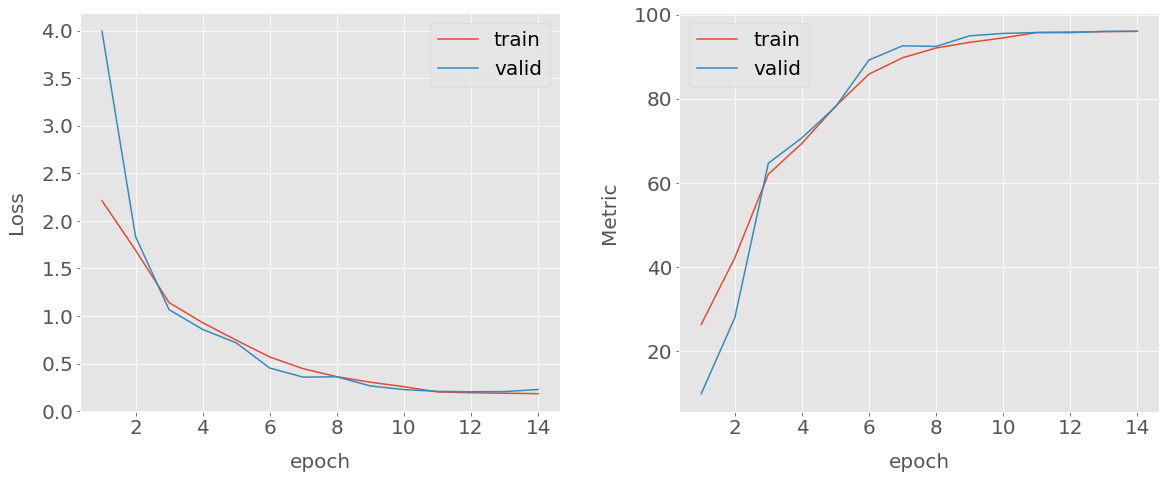

In [178]:
ignore = 6
plot_training_results(
    epochs-ignore, 
    loss_df['train'][ignore:], 
    loss_df['valid'][ignore:], 
    metrics_df['train'][ignore:], 
    metrics_df['valid'][ignore:]
)

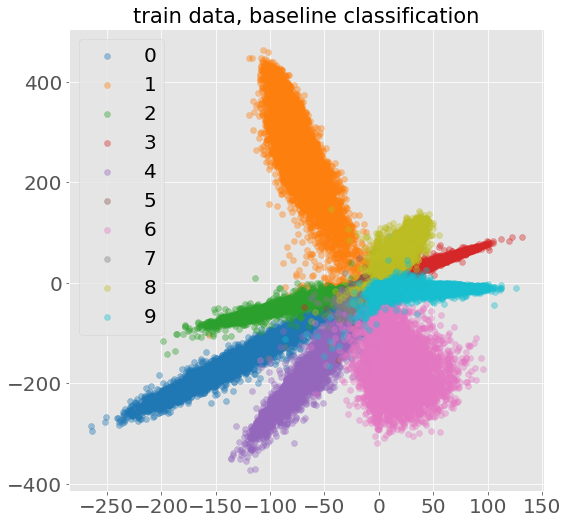

In [181]:
baseline_train_embeddings, baseline_train_labels = extract_embeddings(classification_net, train_dataloader, device)
plot_embeddings(baseline_train_embeddings, baseline_train_labels, 'train data, baseline classification')

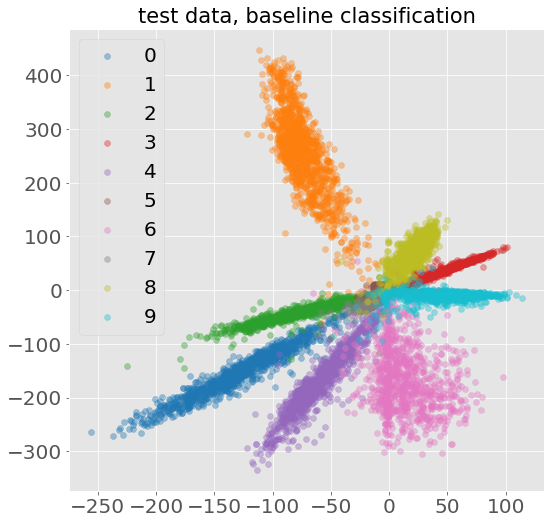

In [182]:
baseline_test_embeddings, baseline_test_labels = extract_embeddings(classification_net, test_dataloader, device)
plot_embeddings(baseline_test_embeddings, baseline_test_labels, 'test data, baseline classification')

## Siamese network, pairwise training examples, contrastive loss

In [269]:
siamese_train_dataset = SiameseMNISTDataset(train_dataset)
siamese_test_dataset = SiameseMNISTDataset(test_dataset, siamese_train_dataset.labels_set)

In [194]:
siamese_train_dataset[0][0][0].size(), siamese_train_dataset[0][0][1].size(), siamese_train_dataset[0][1]

(torch.Size([1, 28, 28]), torch.Size([1, 28, 28]), 1)

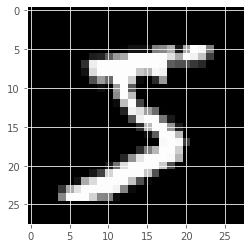

In [195]:
show_image(siamese_train_dataset[0][0][0][0])  # example_idx, data, pair, channel

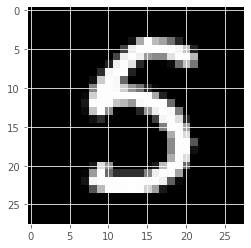

In [196]:
show_image(siamese_train_dataset[0][0][1][0])

In [270]:
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

siamese_train_dataloader = DataLoader(
    siamese_train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    **kwargs
)

siamese_test_dataloader = DataLoader(
    siamese_test_dataset,
    batch_size=batch_size,
    shuffle=True,
    **kwargs
)

In [466]:
siamese_net1 = SiameseNet(EmbeddingNet())

In [467]:
epochs = 20
log_every = 100
margin = 1.

In [468]:
optimizer = torch.optim.RMSprop(siamese_net1.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1, last_epoch=-1)
loss_func = ContrastiveLoss(margin)

In [469]:
loss_df, _ = fit(siamese_net1, optimizer, scheduler, loss_func, siamese_train_dataloader, siamese_test_dataloader, [], device, epochs, log_every)


Train: 256/60000, (0.4%	Loss: 0.246)
Train: 25856/60000, (43.0%	Loss: 0.216)
Train: 51456/60000, (85.5%	Loss: 0.079)
Epoch: 1/20. Train set: Average loss 0.136
Epoch: 1/20. Valid. set: Average loss 0.067

 ----- 

Train: 256/60000, (0.4%	Loss: 0.079)
Train: 25856/60000, (43.0%	Loss: 0.058)
Train: 51456/60000, (85.5%	Loss: 0.050)
Epoch: 2/20. Train set: Average loss 0.054
Epoch: 2/20. Valid. set: Average loss 0.049

 ----- 

Train: 256/60000, (0.4%	Loss: 0.047)
Train: 25856/60000, (43.0%	Loss: 0.044)
Train: 51456/60000, (85.5%	Loss: 0.038)
Epoch: 3/20. Train set: Average loss 0.040
Epoch: 3/20. Valid. set: Average loss 0.041

 ----- 

Train: 256/60000, (0.4%	Loss: 0.041)
Train: 25856/60000, (43.0%	Loss: 0.032)
Train: 51456/60000, (85.5%	Loss: 0.029)
Epoch: 4/20. Train set: Average loss 0.030
Epoch: 4/20. Valid. set: Average loss 0.028

 ----- 

Train: 256/60000, (0.4%	Loss: 0.029)
Train: 25856/60000, (43.0%	Loss: 0.025)
Train: 51456/60000, (85.5%	Loss: 0.022)
Epoch: 5/20. Train set: Ave

In [472]:
metric = DistanceLossPrecisionRecall([0.03, 0.1, 0.3, 1.0, 2.0, 3.0], 'distance')

evaluate_precision_recall(siamese_net, siamese_train_dataloader, metric, device)
train_metrics_df = metric.value()

evaluate_precision_recall(siamese_net, siamese_test_dataloader, metric, device)
test_metrics_df = metric.value()


In [473]:
train_metrics_df

,threshold,precision,recall
0,0.03,1.000000,0.245283
1,0.10,1.000000,0.773585
2,0.30,1.000000,0.943396
3,1.00,0.981481,1.000000
4,2.00,0.768116,1.000000
5,3.00,0.569892,1.000000


In [474]:
test_metrics_df

,threshold,precision,recall
0,0.03,1.000000,0.142857
1,0.10,1.000000,0.571429
2,0.30,1.000000,0.857143
3,1.00,1.000000,1.000000
4,2.00,0.700000,1.000000
5,3.00,0.466667,1.000000


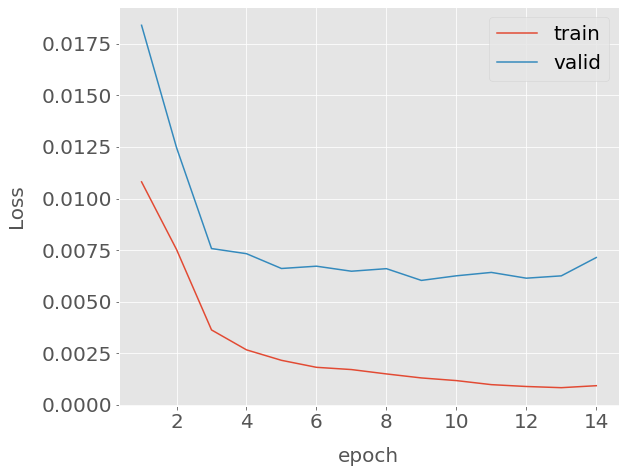

In [475]:
ignore = 6
plot_training_results(
    epochs-ignore, 
    loss_df['train'][ignore:], 
    loss_df['valid'][ignore:], 
    [],
    []
)

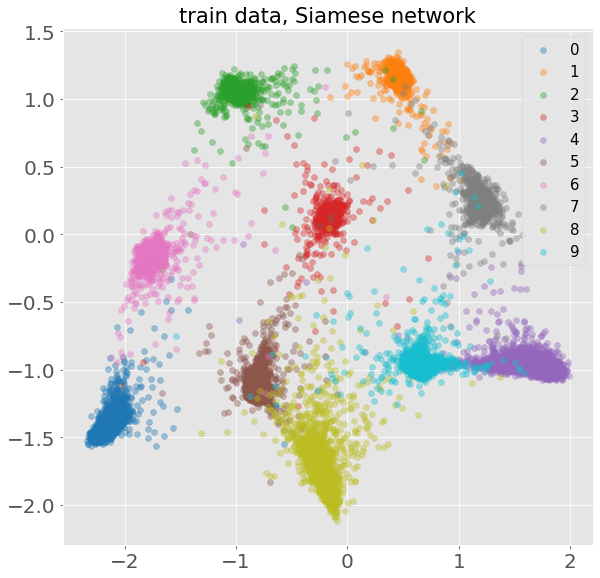

In [476]:
# notice that we use train_dataloader to load single images
siamese_train_embeddings, siamese_train_labels = extract_embeddings(siamese_net, train_dataloader, device)
plot_embeddings(siamese_train_embeddings, siamese_train_labels, 'train data, Siamese network')

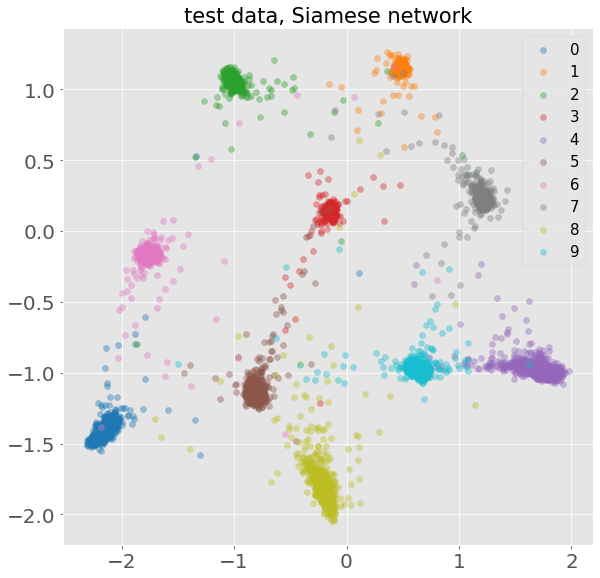

In [477]:
# notice that we use test_dataloader to load single images
siamese_test_embeddings, siamese_test_labels = extract_embeddings(siamese_net, test_dataloader, device)
plot_embeddings(siamese_test_embeddings, siamese_test_labels, 'test data, Siamese network')

## Siamese network, pairwise training examples, Binary logits loss

In [393]:
siamese_net2 = SiameseNet2(EmbeddingNet())

In [394]:
epochs = 20
log_every = 100
margin = 1.

In [395]:
optimizer = torch.optim.RMSprop(siamese_net2.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1, last_epoch=-1)
loss_func = torch.nn.NLLLoss(reduction='mean')

In [396]:
loss_df, _ = fit(siamese_net2, optimizer, scheduler, loss_func, siamese_train_dataloader, siamese_test_dataloader, [], device, epochs, log_every)


Train: 256/60000, (0.4%	Loss: 0.813)
Train: 25856/60000, (43.0%	Loss: 0.577)
Train: 51456/60000, (85.5%	Loss: 0.434)
Epoch: 1/20. Train set: Average loss 0.491
Epoch: 1/20. Valid. set: Average loss 0.383

 ----- 

Train: 256/60000, (0.4%	Loss: 0.417)
Train: 25856/60000, (43.0%	Loss: 0.361)
Train: 51456/60000, (85.5%	Loss: 0.320)
Epoch: 2/20. Train set: Average loss 0.333
Epoch: 2/20. Valid. set: Average loss 0.340

 ----- 

Train: 256/60000, (0.4%	Loss: 0.382)
Train: 25856/60000, (43.0%	Loss: 0.277)
Train: 51456/60000, (85.5%	Loss: 0.258)
Epoch: 3/20. Train set: Average loss 0.264
Epoch: 3/20. Valid. set: Average loss 0.280

 ----- 

Train: 256/60000, (0.4%	Loss: 0.193)
Train: 25856/60000, (43.0%	Loss: 0.221)
Train: 51456/60000, (85.5%	Loss: 0.210)
Epoch: 4/20. Train set: Average loss 0.213
Epoch: 4/20. Valid. set: Average loss 0.714

 ----- 

Train: 256/60000, (0.4%	Loss: 0.583)
Train: 25856/60000, (43.0%	Loss: 0.194)
Train: 51456/60000, (85.5%	Loss: 0.175)
Epoch: 5/20. Train set: Ave

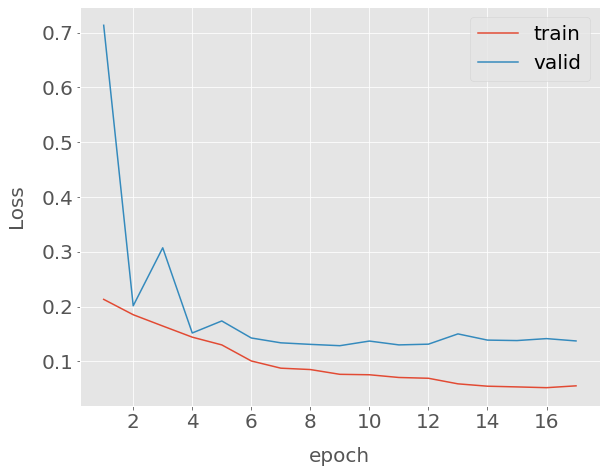

In [397]:
ignore = 3
plot_training_results(
    epochs-ignore, 
    loss_df['train'][ignore:], 
    loss_df['valid'][ignore:], 
    [],
    []
)

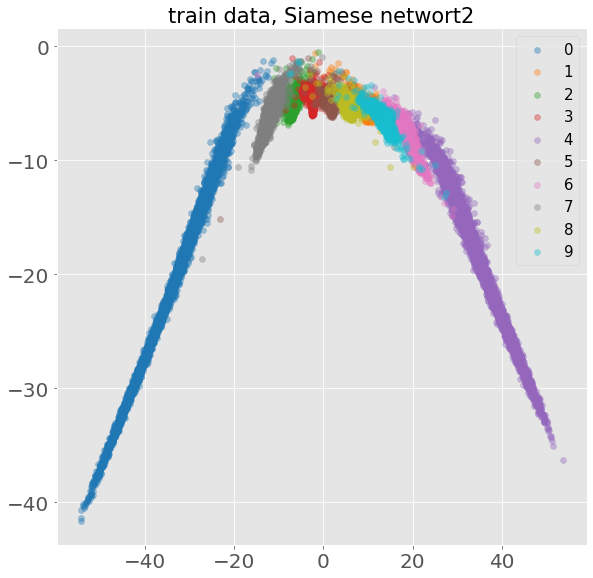

In [398]:
siamese2_test_embeddings, siamese2_test_labels = extract_embeddings(siamese_net2, test_dataloader, device)
plot_embeddings(siamese2_test_embeddings, siamese2_test_labels, 'train data, Siamese networt2')

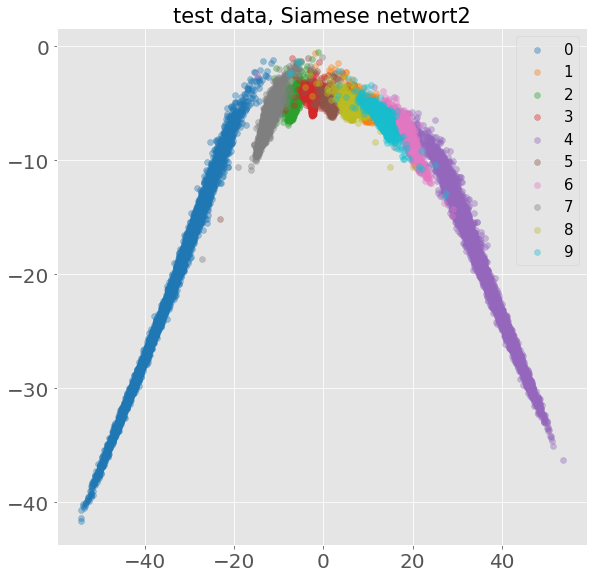

In [399]:
siamese2_train_embeddings, siamese2_train_labels = extract_embeddings(siamese_net2, train_dataloader, device)
plot_embeddings(siamese2_train_embeddings, siamese2_train_labels, 'test data, Siamese networt2')

In [463]:
metric = LogisticLossPrecisionRecall([0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 0.9], 'logistic')

evaluate_precision_recall(siamese_net2, siamese_train_dataloader, metric, device)
train_metrics_df = metric.value()

evaluate_precision_recall(siamese_net2, siamese_test_dataloader, metric, device)
test_metrics_df = metric.value()


In [464]:
train_metrics_df

,threshold,precision,recall
0,0.1,0.927273,1.000000
1,0.2,0.980769,1.000000
2,0.4,1.000000,1.000000
3,0.5,1.000000,1.000000
4,0.6,1.000000,0.980392
5,0.8,1.000000,0.960784
6,0.9,1.000000,0.901961


In [465]:
test_metrics_df

,threshold,precision,recall
0,0.1,1.0,1.000
1,0.2,1.0,1.000
2,0.4,1.0,1.000
3,0.5,1.0,1.000
4,0.6,1.0,1.000
5,0.8,1.0,1.000
6,0.9,1.0,0.875
